In [1]:
import numpy as np
import matplotlib.pyplot as plt   
from scipy import stats
import os
import random
import re
from skbio.diversity.alpha import *

In [86]:
def go_edge(tseries):
    nregions=tseries.shape[1]
    Blen=tseries.shape[0]
    nedges=int(nregions**2/2-nregions/2)
    iTriup= np.triu_indices(nregions,k=1) 
    gz=stats.zscore(tseries,nan_policy='omit')
    Eseries = gz[:,iTriup[0]]*gz[:,iTriup[1]]
    return Eseries

def edges_str(Bold):
    return(np.sqrt(np.sum(go_edge(Bold)**2,axis=1)))

def edges_var(Bold):
    a=edges_str(Bold)
    G=go_edge(Bold)
    Blen=len(a)
    top=G[a>np.percentile(a,95),:]
    dFC=np.corrcoef(top)
    return(np.mean(dFC))
    #return(np.sum(np.abs(a[1:]-a[:Blen-1]))/Blen)

def simpsonbis(Bold_sim):
    C=(np.corrcoef(go_edge(Bold_sim)))
    T=C[np.triu_indices(C.shape[0],k=1)]
    if np.isnan(T).any():
        return(0)
    I=np.unique(np.around(T,decimals=2),return_counts=True)
    return(simpson(I[1]))

In [3]:
def functional_hub(Bold,nregions=5):
    #Return the nregions regions having the biggest participation in the 3 biggest eigenvectors (moduled by the eigenvalues)
    #The regions are sorted in a decreasing importance 
    
    FC=np.corrcoef(Bold.T)
    if np.isnan(FC).any():
        M=np.zeros(nregions)
        M[:]=np.nan
        return(M)
    D,E=np.linalg.eig(FC)
    order=np.argsort(np.sum(np.abs(E[:,:3])*D[:3],axis=1))
    return(np.flip(order[-nregions:]))

def common_hubs(B1,B2,n=8):
    hub1=functional_hub(B1,nregions=n)
    hub2=functional_hub(B2,nregions=n)
    return(np.intersect1d(hub1,hub2))

def predictive_power(B1,B2):
    FC1=np.corrcoef(B1.T)
    FC2=np.corrcoef(B2.T)
    T1=FC1[np.triu_indices(FC1.shape[0],k=1)]
    T2=FC2[np.triu_indices(FC2.shape[0],k=1)]
    if np.isnan([FC1,FC2]).any():
        return([0,0])
    return(stats.pearsonr(T1,T2))

def best_PP(Bold,Bsim):
    m=Bsim.shape[2]
    M=np.zeros(m)
    for k in range(m):
        M[k]=predictive_power(Bold,Bsim[:,:,k])[0]
    return(np.argwhere(M == np.amax(M)),np.amax(M))

In [4]:
path='/home/etienne/data/simulation_second_batch/'
path2='/home/etienne/data/dataXetien/'

remove_roi=[55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,
            129, 130,  131,  132,  133,  134,  135,  136,  137,  138,  139,  140, 141, 142, 143,144,145,146,147, 27, 101]

In [50]:
Blen=2000
nregions=148
file_number=(len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))]))
B=np.zeros((Blen,nregions,file_number))
param=np.zeros((file_number,2))
regex = re.compile('\d*\.?\d+')

i=0
for filename in os.listdir(path):
    bold=np.load(path+filename)['Bold_data'][-Blen:,0,:]
    G,N=np.array(regex.findall(filename),dtype='float')[1:]
    B[:,:,i]=bold
    param[i,:]=np.round(G,decimals=3),np.round(N,decimals=3)
    i+=1

In [10]:
data=np.load(path2+'EPI_DMN_A30_CNO_Wt89{}_Baseline.npy'.format(34))
Blen=data.shape[0]
nregions=data.shape[1]-len(remove_roi)
Bemp=np.zeros((8,Blen,nregions))
i=0
for k in [34,36,38,40,41,42,43,44]:
    bold=np.load(path2+'EPI_DMN_A30_CNO_Wt89{}_Baseline.npy'.format(k))
    bold=np.delete(bold,remove_roi,axis=1)
    Bemp[i,:,:]=bold
    i+=1

In [51]:
G_LIST     = list(np.round(np.arange(0.45,0.75,0.005),decimals=3))
N_LIST     = list(np.round(np.arange(0.02,0.06,0.002),decimals=3))
paramset=np.zeros((len(G_LIST),len(N_LIST)))
k,j=0,0
for kk in G_LIST:
    j=0
    for jj in N_LIST:
        if [kk,jj] in param.tolist():
            paramset[k,j]=1
        j+=1
    k+=1

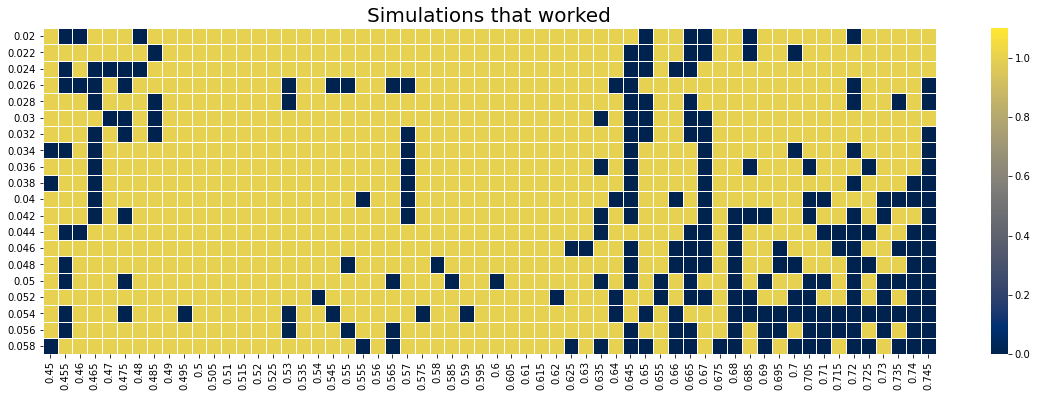

In [52]:
import seaborn as sns
plt.figure(figsize=(20,6))
plt.title('Simulations that worked',fontdict={'fontsize':20})

ax=sns.heatmap(paramset.T,cmap='cividis',linewidths=.8,xticklabels=G_LIST,yticklabels=N_LIST,vmax=1.1)


<ipython-input-144-f1564d60d037>:7: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.title('B1'+np.str(param[k,:]),fontsize=18)


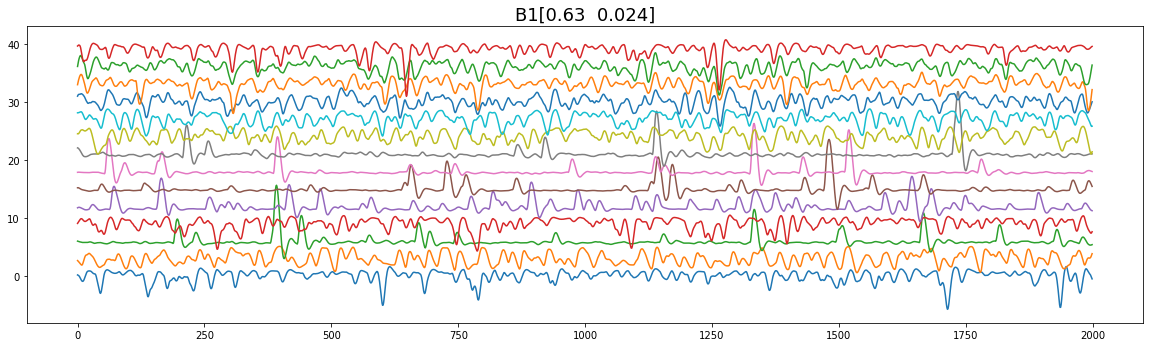

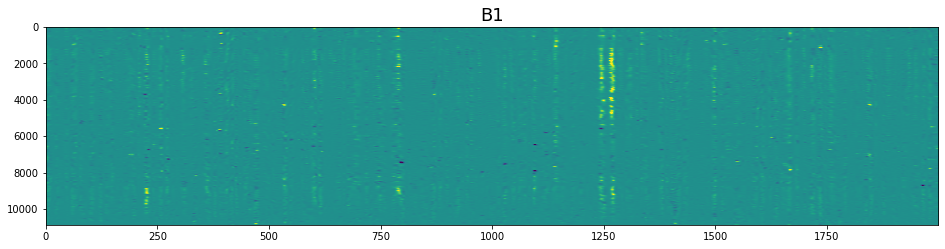

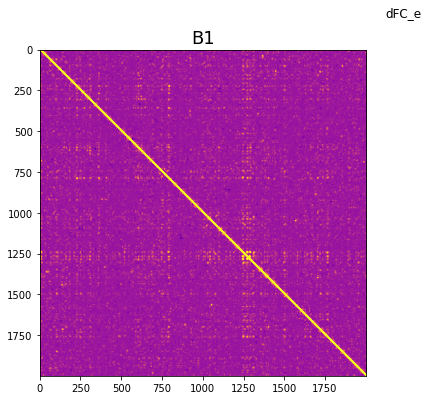

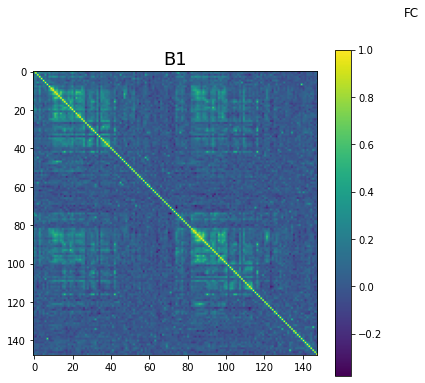

In [144]:
G=0.63
N=0.024
k=(np.where((param[:,0]==G)&(param[:,1]==N)))[0][0]
B1=B[:,:,k]
plt.figure(figsize=(20,12))
plt.subplot(211)
plt.title('B1'+np.str(param[k,:]),fontsize=18)
for i in range(14):
    plt.plot(stats.zscore(B1[:,i])+3*i)
    
    
plt.figure(figsize=(16,8))
plt.subplot(211)
plt.title('B1',fontsize=18)
plt.imshow(go_edge(B1).T,vmin=-5.,vmax=5.,aspect='auto')

plt.figure(figsize=(14,6))
plt.suptitle('dFC_e')
plt.subplot(121)
plt.title('B1',fontsize=18)
plt.imshow(np.corrcoef(go_edge(B1)),cmap='plasma',vmax=0.25)

plt.figure(figsize=(14,6))
plt.suptitle('FC')
plt.subplot(121)
plt.title('B1',fontsize=18)
plt.imshow(np.corrcoef(B1.T))
plt.colorbar()

In [87]:
#MEASUREG=np.zeros(B.shape[2])
#MEASURES=np.zeros(B.shape[2])
MEASUREM=np.zeros(B.shape[2])

for i in range(B.shape[2]):
    #MEASUREG[i]=edges_var(B[:,:,i])
    #MEASURES[i]=simpsonbis(B[:,:,i])
    MEASUREM[i]=edges_var(B[:,:,i])

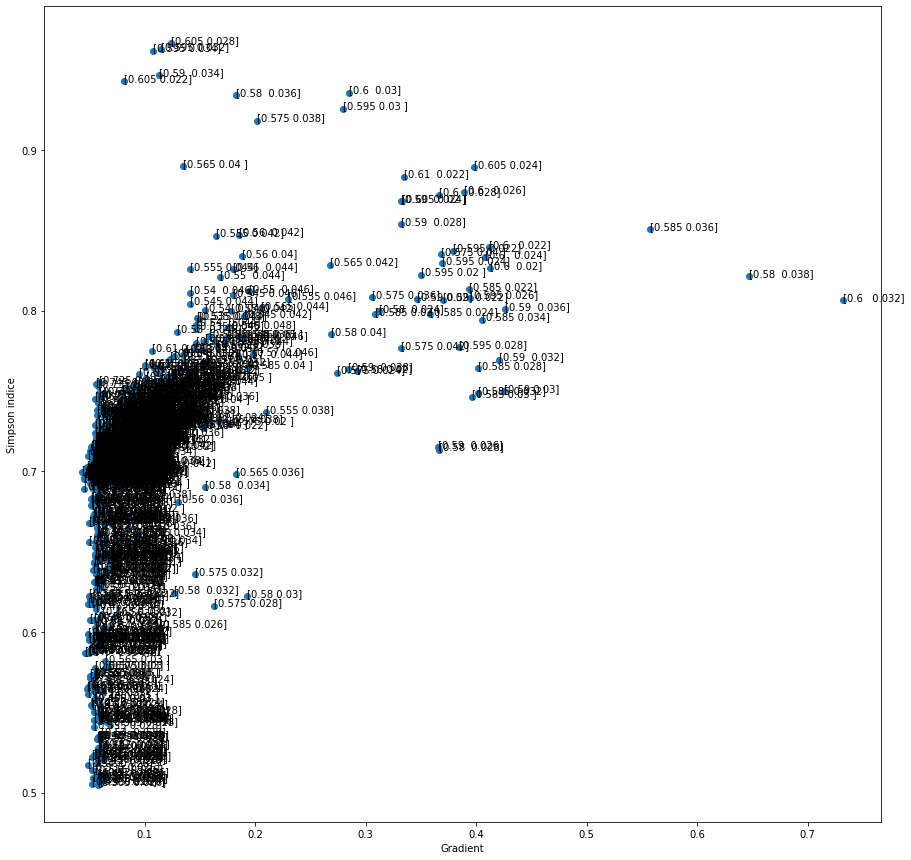

In [92]:
annotations = param

plt.figure(figsize=(15,15))
plt.scatter(MEASUREM,MEASURES)
plt.xlabel('Gradient')
plt.ylabel('Simpson indice')
for i, label in enumerate(annotations):
    plt.annotate(label, (MEASUREM[i], MEASURES[i]))
plt.show()

In [110]:
hub_number=12
m=B.shape[2]
q=Bemp.shape[0]
Common_hubs=np.zeros((m,q))
Bsimbis=np.delete(B,remove_roi,axis=1)

for k in range(m):
    inter=np.zeros(q)
    for i in range(q):
        hubs=common_hubs(Bemp[i,:,:],Bsimbis[:,:,k],n=hub_number)
        inter[i]=len(hubs)
    Common_hubs[k,:]=inter

/home/etienne/env/lib/python3.8/site-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


[Text(0.5, 51.0, 'Parameter couple'), Text(159.0, 0.5, 'Empirical dataset')]

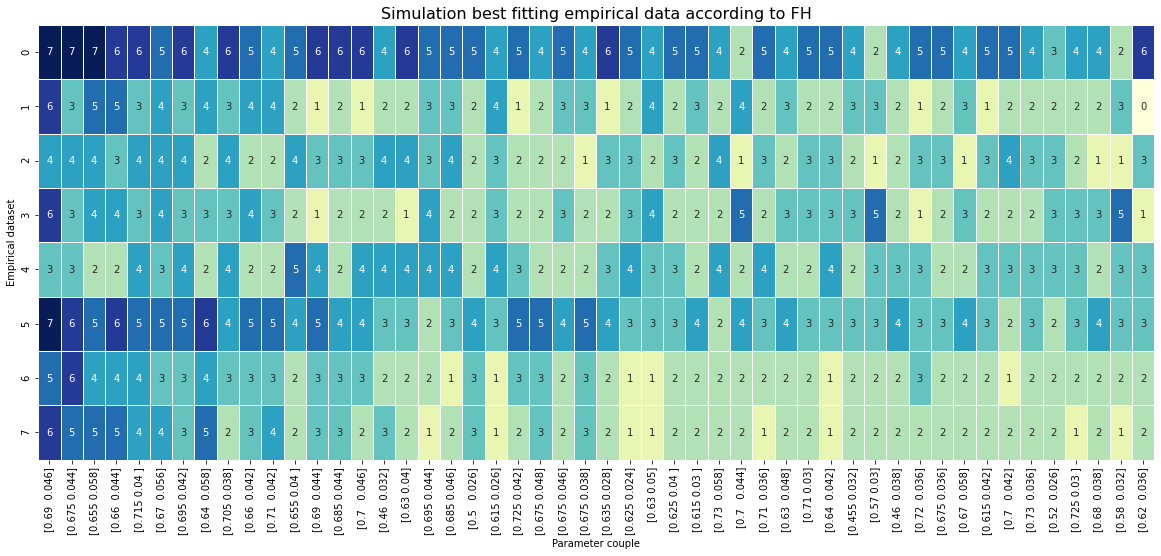

In [111]:
Count=np.sum(Common_hubs,axis=1)
sortedsim=(np.flip(np.unravel_index(np.argsort(Count, axis=None), Count.shape)[0]))
num_sim=50

to_plot=Common_hubs[sortedsim[:num_sim],:]
plt.figure(figsize=(20,8))
plt.title('Simulation best fitting empirical data according to FH',fontdict={'fontsize':16})
ax = sns.heatmap(to_plot.T, cmap='YlGnBu',annot=True,xticklabels=param[sortedsim[:num_sim],:],cbar=False,linewidths=.8)
ax.set(xlabel="Parameter couple", ylabel = "Empirical dataset")

In [128]:
m=B.shape[2]
q=Bemp.shape[0]
PP=np.zeros((m,q))
Bsimbis=np.delete(B,remove_roi,axis=1)

for k in range(m):
    inter=np.zeros(q)
    for i in range(q):
        pp=predictive_power(Bemp[i,:,:],Bsimbis[:,:,k])
        inter[i]=pp[0]
    PP[k,:]=inter
Bestpp=np.max(PP,axis=1)

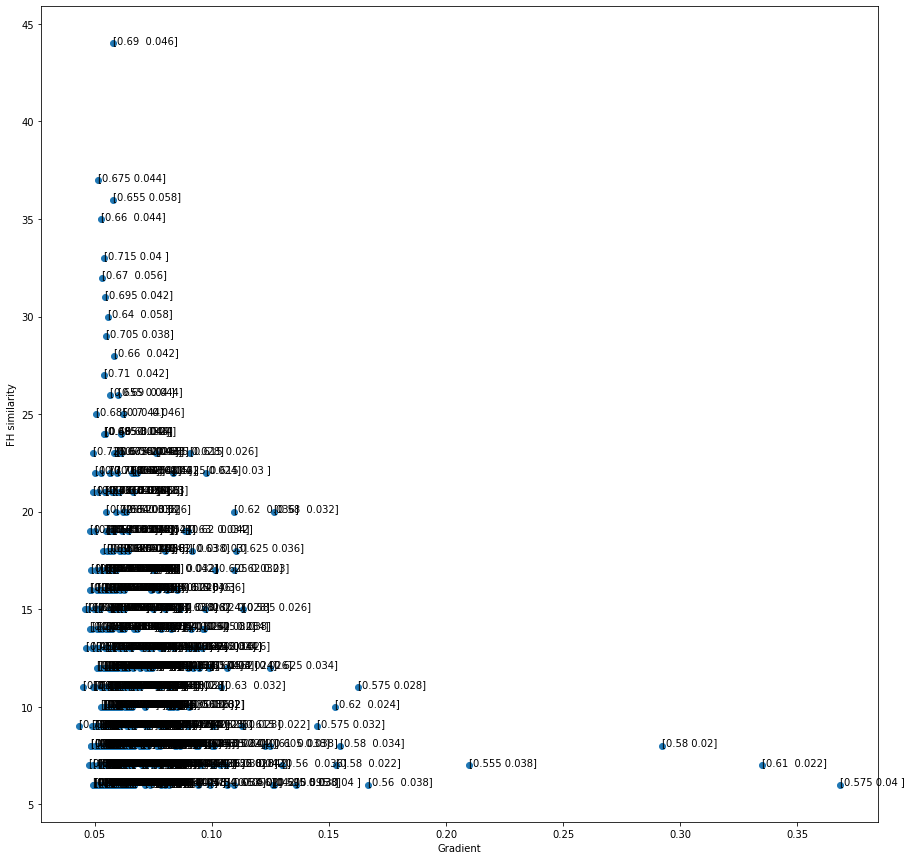

In [112]:
k=5
annotations = param[Count>k]

plt.figure(figsize=(15,15))
plt.scatter(MEASUREM[Count>k],Count[Count>k])
plt.xlabel('Gradient')
plt.ylabel('FH similarity')
for i, label in enumerate(annotations):
    plt.annotate(label, (MEASUREM[Count>k][i], Count[Count>k][i]))
plt.show()

/home/etienne/env/lib/python3.8/site-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


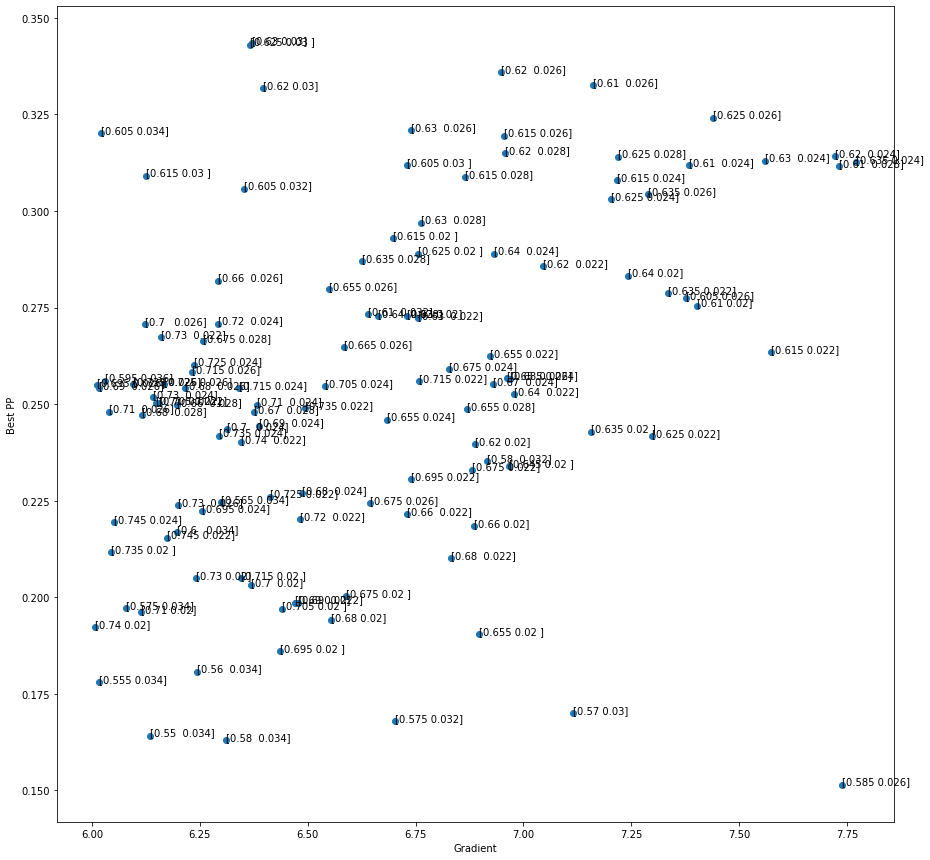

In [142]:
annotations = param[(MEASUREG>6)&(Bestpp>0.15)]

plt.figure(figsize=(15,15))
plt.scatter(MEASUREG[(MEASUREG>6)&(Bestpp>0.15)],Bestpp[(MEASUREG>6)&(Bestpp>0.15)])
plt.xlabel('Gradient')
plt.ylabel('Best PP')
for i, label in enumerate(annotations):
    plt.annotate(label, (MEASUREG[(MEASUREG>6)&(Bestpp>0.15)][i], Bestpp[(MEASUREG>6)&(Bestpp>0.15)][i]))
plt.show()

In [117]:
G_LIST     = list(np.round(np.arange(0.45,0.75,0.005),decimals=3))
N_LIST     = list(np.round(np.arange(0.02,0.06,0.002),decimals=3))
mG=stats.zscore(MEASUREG)
toplot=np.zeros((len(G_LIST),len(N_LIST)))
k,j=0,0
for kk in G_LIST:
    j=0
    for jj in N_LIST:
        if [kk,jj] in param.tolist():
            m=(np.where((param[:,0]==kk)&(param[:,1]==jj)))[0][0]
            toplot[k,j]=MEASURES[m]+mG[m]
        j+=1
    k+=1

plt.figure(figsize=(18,6))
plt.imshow(toplot.T,aspect='auto',interpolation='nearest',cmap='viridis');
plt.xticks(np.arange(len(G_LIST)),np.around(G_LIST,3),rotation=60,fontsize=12);
plt.yticks(np.arange(len(N_LIST)),np.around(N_LIST,3)[::-1],fontsize=12);plt.title('Variance of the dFC', fontsize=20);
plt.colorbar();plt.xlabel('Global Coupling G',fontsize=16);plt.ylabel('Noise',fontsize=16);
plt.tight_layout()
plt.show()